In [1]:
import xarray as xr
import xmitgcm
import xgcm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import ipywidgets
import dask
import cmocean
import pandas as pd

import gsw

# Initialise Cluster

In [2]:
import os
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster
walltime = '04:00:00'
cores = 28
memory = '250GB'
  
cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P jk72','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/jk72+gdata/v45+gdata/qv56+gdata/hh5+gdata/cj50',
                                '-l jobfs=60GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     # python=os.environ["DASK_PYTHON"]
                    )


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
cluster.scale(jobs=1)

In [5]:
# cluster = SLURMCluster(cores=16,memory="47GB", walltime='02:00:00')

# cluster = 'tcp://10.0.128.138:38535'

In [4]:
!qstat

Job id                 Name             User              Time Use S Queue
---------------------  ---------------- ----------------  -------- - -----
65313644.gadi-pbs      sys-dashboard-s* ed7737            00:02:02 R normalbw-exec   
65328169.gadi-pbs      layer_decomp     ed7737            03:28:00 R normalbw-exec   


In [5]:
cluster

In [6]:
# either way, run this
client = Client(cluster)


In [7]:
print(client)

<Client: 'tcp://10.6.121.2:37587' processes=0 threads=0, memory=0 B>


In [67]:
client.write_scheduler_file("/g/data/jk72/ed7737/SO-channel_embayment/analysis/dask_scheduler.json")


ValueError: Scheduler file already set

# Load datasets

In [8]:
model_dir = '/g/data/jk72/ed7737/SO-channel_embayment/simulations/run/'

In [11]:
iters = np.fromfile('/g/data/jk72/ed7737/SO-channel_embayment/simulations/run/iters.txt', dtype=int, sep=',')

In [12]:
iters = iters.tolist()

In [13]:
iters = iters[-720:]
len(iters)

720

In [14]:
ds_2d = xmitgcm.open_mdsdataset(data_dir=model_dir+'/Diags', grid_dir=model_dir,
                                prefix=['2D_diags'], delta_t=500, calendar='360_day',
                                ref_date='2000-1-1 0:0:0', geometry='Cartesian',
                               iters=iters)

In [15]:
ds_seaice = xmitgcm.open_mdsdataset(data_dir=model_dir+'/Diags', grid_dir=model_dir,
                                    prefix=['seaIceDiag'], delta_t=500, calendar='360_day',
                                    ref_date='2000-1-1 0:0:0', geometry='Cartesian',
                               iters=iters)

In [16]:
ds_heat = xmitgcm.open_mdsdataset(data_dir=model_dir+'/Diags', grid_dir=model_dir,
                                      prefix=['heat_3D'], delta_t=500, calendar='360_day',
                                      ref_date='2000-1-1 0:0:0', geometry='Cartesian',
                               iters=iters)


In [17]:
ds_state = xmitgcm.open_mdsdataset(data_dir=model_dir+'/Diags', grid_dir=model_dir,
                                   prefix=['state'], delta_t=500, calendar='360_day',
                                   ref_date='2000-1-1 0:0:0', geometry='Cartesian',
                               iters=iters)

## Define grid and metrics

In [18]:
ds_state['drW'] = ds_state.hFacW * ds_state.drF #vertical cell size at u point
ds_state['drS'] = ds_state.hFacS * ds_state.drF #vertical cell size at v point
ds_state['drC'] = ds_state.hFacC * ds_state.drF #vertical cell size at tracer point

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}

grid = xgcm.Grid(ds_state, periodic=['X'], metrics=metrics)
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * right    Zu --> center
  * left     Zl --> center

# Analysis

## Intial Exploration

In [23]:
ds_2d['TFLUX']

<xarray.DataArray 'TFLUX' (time: 720, YC: 360, XC: 200)>
dask.array<concatenate, shape=(720, 360, 200), dtype=float32, chunksize=(1, 360, 200), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 5e+03 1.5e+04 2.5e+04 ... 1.975e+06 1.985e+06 1.995e+06
  * YC       (YC) >f4 5e+03 1.5e+04 2.5e+04 ... 3.575e+06 3.585e+06 3.595e+06
    rA       (YC, XC) >f4 dask.array<chunksize=(360, 200), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(360, 200), meta=np.ndarray>
    dxF      (YC, XC) >f4 dask.array<chunksize=(360, 200), meta=np.ndarray>
    dyF      (YC, XC) >f4 dask.array<chunksize=(360, 200), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) object 2110-01-06 00:00:00 ... 2120-01-01 00:00:00
Attributes:
    standard_name:  TFLUX
    long_name:      total heat flux (match heat-content variations), >0 incre...
    units:          W/m^2

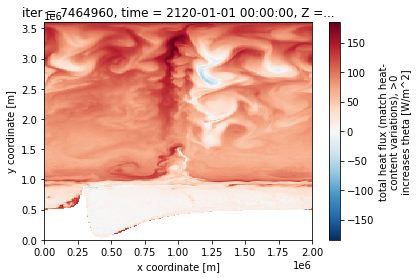

In [24]:
ds_2d['TFLUX'].where(ds_state['hFacC'].sel(Z=0, method='nearest')>0).sel(time=ds_2d['time'][-1]).plot()

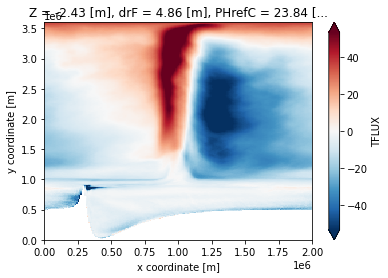

In [25]:
ds_2d['TFLUX'].where(ds_state['hFacC'].sel(Z=0, method='nearest')>0).sel(time=slice('2110-01-01', '2120-01-01')).mean(dim='time').plot(robust=True)

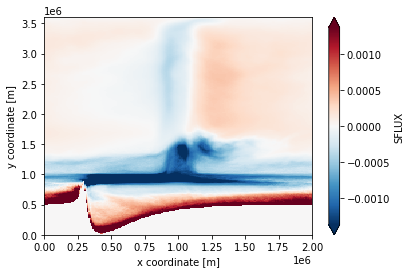

In [26]:
ds_2d['SFLUX'].sel(time=slice('2110-01-01', '2120-01-01')).mean(dim='time').plot(robust=True)

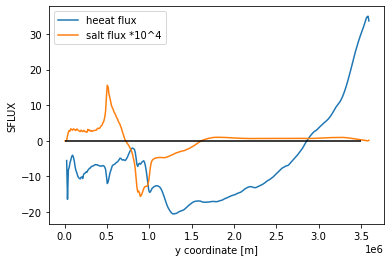

In [27]:
ds_2d['TFLUX'].where(ds_state['hFacC'].sel(Z=0, method='nearest')>0).sel(time=slice('2110-01-01', '2120-01-01')).mean(dim=['time', 'XC']).plot(label='heeat flux')
(1e4*ds_2d['SFLUX']).sel(time=slice('2110-01-01', '2120-01-01')).mean(dim=['time', 'XC']).plot(label='salt flux *10^4')
plt.legend()
plt.hlines(0,0,3.5e6, color='k')

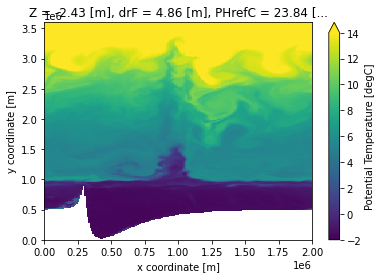

In [28]:
ds_state['THETA'].where(ds_state['SALT']>0).sel(Z=0, method='nearest').sel(time=ds_state['time'][-1], method='nearest').plot(vmin=-2, vmax=14)

In [29]:
def plot_temperature(i, xloc, save=False):
    fig, ax = plt.subplots(1,3, figsize=(18,4))
    
    ds_state['THETA'].where(ds_state['SALT']>0).sel(XC=xloc, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[0],
                                                                                                          vmin=-1.8, vmax=10,
                                                                                                         cmap=cmocean.cm.thermal)
    (-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][i])).plot(color='k', ax=ax[0])
    # ds_layers['LaTr3RHO'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_layers['time'][int(np.floor(i/72)-1)]).plot.contour(
    #                 levels=np.linspace(31,35,40), ax=ax[0])


    ds_2d['MXLDEPTH'].sel(time=ds_2d['time'][i]).plot.contour(ax=ax[1],
                                                             levels=[1,10,50,
                                                                     100,200,300,400,500,600,700,800,900,1000,
                                                                     1200,1400,1600,1800,2000])
    ds_state['THETA'].where(ds_state['SALT']>0).sel(Z=0, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[1],
                                                                                                      vmin=-1.8, vmax=10,
                                                                                                      cmap=cmocean.cm.thermal)
    ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][i]).where(
            ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][i])>0.15).plot(cmap='binary_r', ax=ax[1], vmin=0, vmax=1, zorder=3)


    ds_state['THETA'].where(ds_state['SALT']>0).sel(XC=xloc, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[2],
                                                                                                          vmin=-1.8, vmax=10,
                                                                                                         cmap=cmocean.cm.thermal)
    ax[2].set_ylim(-1500,0)
    # ds_layers['LaTr3RHO'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_layers['time'][int(np.floor(i/72)-1)]).plot.contour(
    #                 levels=np.linspace(31,35,40), ax=ax[2])
    (-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][i])).plot(color='k', ax=ax[2])


    if save:
        plt.savefig('temperature_{0}.png'.format(i), dpi=200, bbox_inches='tight')



In [30]:
t_max = min(ds_state['time'].shape[0]-1, ds_2d['time'].shape[0]-1)

ipywidgets.interactive(plot_temperature,
                       i=ipywidgets.IntSlider(value=t_max, min=0,max=t_max),
                       xloc=ipywidgets.FloatSlider(value=400e3, min=0,max=1e6, step=10e3))

interactive(children=(IntSlider(value=719, description='i', max=719), FloatSlider(value=400000.0, description=…

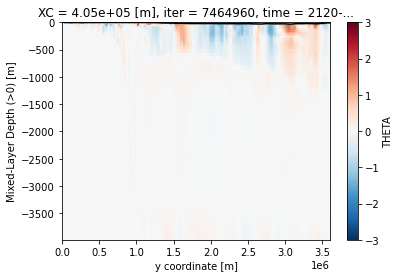

In [31]:
# change in temperature
xloc = 400e3
(ds_state['THETA'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][-1], method='nearest') - 
    ds_state['THETA'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][0], method='nearest')).plot(vmin=-3, vmax=3, cmap='RdBu_r')
(-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][-1])).plot(color='k')



In [32]:
def plot_salinity(i, xloc, save=False):
    fig, ax = plt.subplots(1,3, figsize=(18,4))
    
    ds_state['SALT'].where(ds_state['SALT']>0).sel(XC=xloc, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[0],
                                                                                                          vmin=34, vmax=35,
                                                                                                         cmap=cmocean.cm.haline)
    # ds_layers['LaTr3RHO'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_layers['time'][int(np.floor(i/72))-1]).plot.contour(
    #                 levels=np.linspace(31,35,40), ax=ax[0])
    (-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][i])).plot(color='k', ax=ax[0])


    
    ds_2d['MXLDEPTH'].sel(time=ds_2d['time'][i]).plot.contour(ax=ax[1],
                                                             levels=[1,10,50,
                                                                     100,200,300,400,500,600,700,800,900,1000,
                                                                     1200,1400,1600,1800,2000])
    ds_state['SALT'].where(ds_state['SALT']>0).sel(Z=0, method='nearest').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[1],
                                                                                                      vmin=34, vmax=35,
                                                                                                      cmap=cmocean.cm.haline)
    ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][i]).where(
            ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][i])>0.15).plot(cmap='binary_r', ax=ax[1], vmin=0, vmax=1, zorder=3)


    ds_state['SALT'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_state['time'][i], method='nearest').plot(ax=ax[2],
                                                                                                          vmin=34, vmax=35,
                                                                                                         cmap=cmocean.cm.haline)


    # ds_layers['LaTr3RHO'].where(ds_state['SALT']>0).mean(dim='XC').sel(time=ds_layers['time'][int(np.floor(i/72))-1]).plot.contour(
    #                 levels=np.linspace(31,35,40), ax=ax[2])

    (-ds_2d['MXLDEPTH'].mean(dim='XC').sel(time=ds_2d['time'][i])).plot(color='k', ax=ax[2])
    ax[2].set_ylim(-1400,0)

    if save:
        plt.savefig('salt_{0}.png'.format(i), dpi=200, bbox_inches='tight')




In [33]:
t_max = min(ds_state['time'].shape[0]-1, ds_2d['time'].shape[0]-1)

ipywidgets.interactive(plot_salinity,
                       i=ipywidgets.IntSlider(value=t_max, min=0,max=t_max),
                       xloc=ipywidgets.FloatSlider(value=400e3, min=0,max=1e6, step=10e3))

interactive(children=(IntSlider(value=719, description='i', max=719), FloatSlider(value=400000.0, description=…

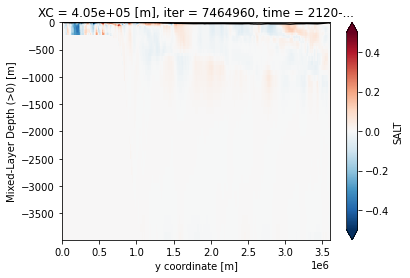

In [34]:
# change in salinity
xloc = 400e3
(ds_state['SALT'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][-1], method='nearest') - 
    ds_state['SALT'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][0], method='nearest')).plot(vmin=-.5, vmax=.5, cmap='RdBu_r')
(-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][-1])).plot(color='k')

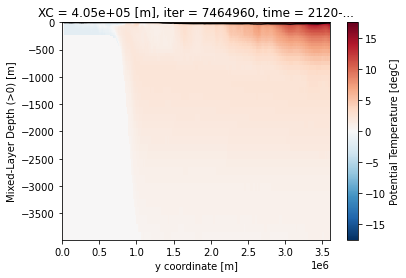

In [35]:
xloc = 400e3
ds_state['THETA'].sel(XC=xloc, method='nearest').sel(time=ds_state['time'][-1], method='nearest').plot()
(-ds_2d['MXLDEPTH'].sel(XC=xloc, method='nearest').sel(time=ds_2d['time'][-1])).plot(color='k')

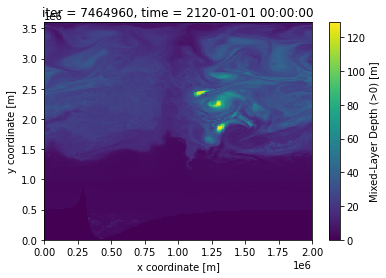

In [36]:
ds_2d['MXLDEPTH'].sel(time=ds_2d['time'][-1], method='nearest').plot()

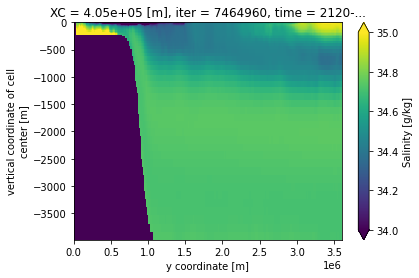

In [37]:
ds_state['SALT'].sel(XC=400e3, method='nearest').sel(time=ds_state['time'][-1], method='nearest').plot(vmin=34, vmax=35)

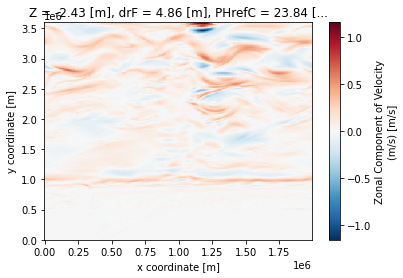

In [38]:
ds_state['UVEL'].sel(Z=0, method='nearest').sel(time=ds_state['time'][-1]).plot()

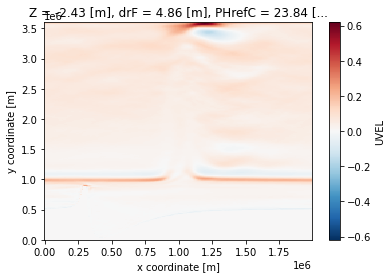

In [39]:
ds_state['UVEL'].sel(Z=0, method='nearest').sel(time=slice('2000-01-01',ds_state['time'][-1])).mean(dim='time').plot()

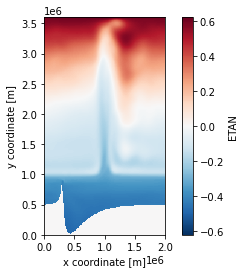

In [40]:
ds_2d['ETAN'].sel(time=slice('2070-01-01',ds_2d['time'][-1])).mean(dim='time').plot()
ax = plt.gca()
ax.set_aspect('equal')
plt.savefig('etan.png', dpi=200, bbox_inches='tight')

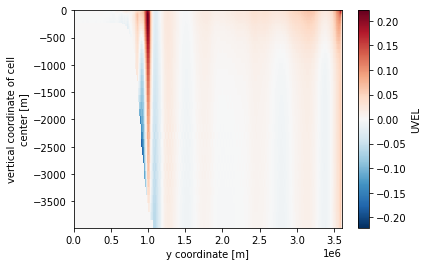

In [41]:
# ds_state['UVEL'].resample(time="1M").mean().mean(dim='XG').sel(time=ds_state['time'][-1], method='nearest').plot()
ds_state['UVEL'].sel(time=slice('2010-01-01', ds_state['time'][-1])).mean(dim=['XG', 'time']).plot()

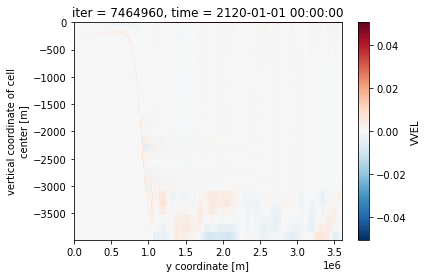

In [42]:
ds_state['VVEL'].mean(dim='XC').sel(time=ds_state['time'][-1]).plot()

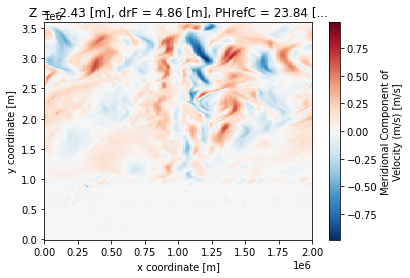

In [43]:
ds_state['VVEL'].sel(Z=0, method='nearest').sel(time=ds_state['time'][-1]).plot()

## Transport

## Sea Ice

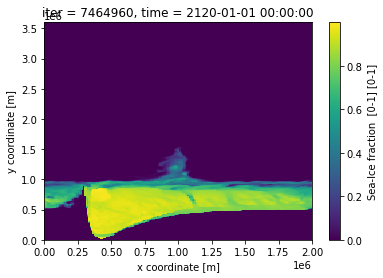

In [44]:
ds_seaice['SI_Fract'].sel(time=ds_seaice['time'][-1]).plot()

In [45]:
sea_ice_time_series = grid.integrate(ds_seaice['SI_Fract'], ['X', 'Y'])/1e12 # in millions of square km

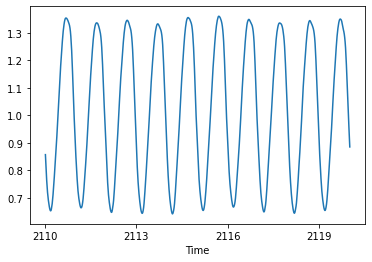

In [46]:
sea_ice_time_series.plot()

## vorticity

## Layers


## Calculate layerwise fluxes using the 5 day snapshots
Define density, regrid `VVEL`, `THETA`, and `ADVy_TH` into density space. Need to multipy `VVEL` and `THETA` by `drF` to make themm extensive quantities. Also regrid an array of `drF` to get the thickness.

In [19]:
time_range = (ds_state['time'][-720], ds_state['time'][-1])
time_range

(<xarray.DataArray 'time' ()>
 array(cftime.Datetime360Day(2110, 1, 6, 0, 0, 0, 0, has_year_zero=True),
       dtype=object)
 Coordinates:
     iter     int64 dask.array<chunksize=(), meta=np.ndarray>
     time     object 2110-01-06 00:00:00
 Attributes:
     standard_name:  time
     long_name:      Time
     axis:           T,
 <xarray.DataArray 'time' ()>
 array(cftime.Datetime360Day(2120, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       dtype=object)
 Coordinates:
     iter     int64 dask.array<chunksize=(), meta=np.ndarray>
     time     object 2120-01-01 00:00:00
 Attributes:
     standard_name:  time
     long_name:      Time
     axis:           T)

In [20]:
mask_TP = xr.where(ds_state['hFacC']>0, 1, 0)

mask_VP = xr.where(ds_state['hFacS']>0, 1, 0)

### Calculate density

In [59]:
sigma1 = gsw.density.sigma2(ds_state['SALT'].where(mask_TP)*1.0047154285714286,
                            ds_state['THETA'].where(mask_TP)).rename('sigma1')

In [60]:
sigma1.min().values

array(31.89275689)

In [61]:
sigma1_bar = sigma1.mean(dim=['time']).load()

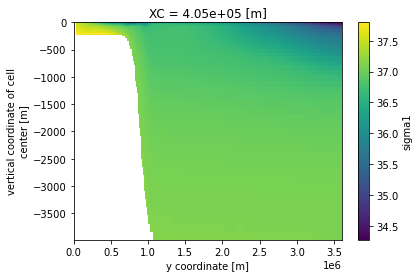

In [62]:
sigma1_bar.sel(XC=0.4e6, method='nearest').plot(y='Z')

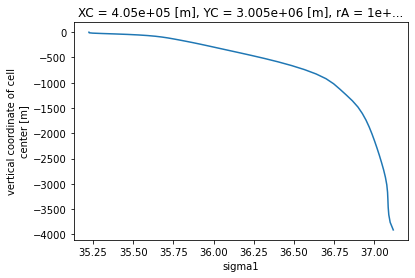

In [63]:
sigma1_bar.sel(XC=0.4e6, method='nearest').sel(YC=3e6, method='nearest').plot(y='Z')

In [64]:
# Thickness of the density layers throughout the water column
delta_h = 100 #m
z = np.arange(-5, -3995, -delta_h)

sigma_bounds = sigma1_bar.sel(XC=0.4e6, method='nearest').sel(YC=3e6, method='nearest').interp(Z=z).values
# Capture the lower densities
n_layers_upper = 11
sigma_bounds_upper = np.linspace(sigma1.min().values, sigma_bounds[0], n_layers_upper, endpoint=False)
# Capture the larger densities
n_layers_lower = 21
sigma_bounds_lower = np.linspace(sigma_bounds[-1] + (sigma_bounds[-1] - sigma_bounds[-2]),
                                 sigma1.max().values, n_layers_lower)

sigma_bounds = np.concatenate((sigma_bounds_upper, sigma_bounds, sigma_bounds_lower))

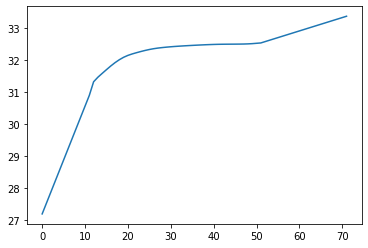

In [58]:
# sigma1
plt.plot(sigma_bounds)

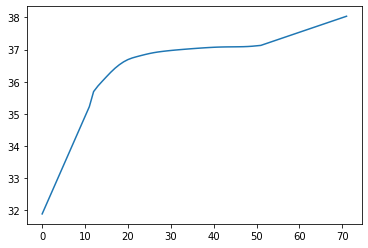

In [65]:
# sigma2
plt.plot(sigma_bounds)

In [49]:
sigma2 = gsw.density.sigma2(ds_state['SALT'].where(mask_TP),
                            ds_state['THETA'].where(mask_TP))



In [50]:
#move to required location for interpolation
sigma2 = grid.interp(sigma2, 'Y', boundary='extend')
sigma2.name = 'sigma2'


sigma2_zp1 = grid.interp(sigma2, 'Z', boundary='extend')#, to='outer')
sigma2_zp1.name = 'sigma2'




In [51]:
sigma2_bar = sigma2.sel(time=slice(time_range[0], time_range[1])).mean(dim='time').compute()
sigma2_zp1_bar = grid.interp(sigma2_bar, 'Z', boundary='extend', to='outer')

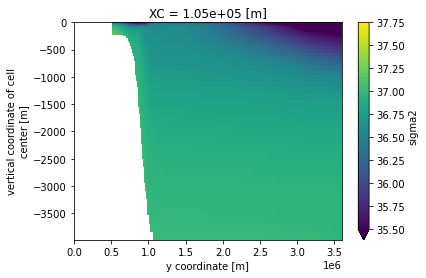

In [52]:
sigma2_bar.sel(XC=0.1e6, method='nearest').plot(vmin=35.5, vmax=37.75)

In [53]:
sigma2_layer_bounds = np.append(np.linspace(31.5,36.8, 53, endpoint=False), np.linspace(36.8, 36.95,3, endpoint=False))
sigma2_layer_bounds = np.append(sigma2_layer_bounds, np.linspace(36.95, 37.1, 6, endpoint=False))
sigma2_layer_bounds = np.append(sigma2_layer_bounds, np.linspace(37.1, 38, 10))

# sigma2_layer_bounds = np.linspace(31.5, 38, 131)
# sigma2_layer_bounds = sigma2_layer_bounds[::-1]

# sigma2_layer_bounds = np.linspace(31.5,38, 261)

sigma2_layer_midpoints = (sigma2_layer_bounds[1:] + sigma2_layer_bounds[:-1])/2

sigma2_layer_bounds

array([31.5  , 31.6  , 31.7  , 31.8  , 31.9  , 32.   , 32.1  , 32.2  ,
       32.3  , 32.4  , 32.5  , 32.6  , 32.7  , 32.8  , 32.9  , 33.   ,
       33.1  , 33.2  , 33.3  , 33.4  , 33.5  , 33.6  , 33.7  , 33.8  ,
       33.9  , 34.   , 34.1  , 34.2  , 34.3  , 34.4  , 34.5  , 34.6  ,
       34.7  , 34.8  , 34.9  , 35.   , 35.1  , 35.2  , 35.3  , 35.4  ,
       35.5  , 35.6  , 35.7  , 35.8  , 35.9  , 36.   , 36.1  , 36.2  ,
       36.3  , 36.4  , 36.5  , 36.6  , 36.7  , 36.8  , 36.85 , 36.9  ,
       36.95 , 36.975, 37.   , 37.025, 37.05 , 37.075, 37.1  , 37.2  ,
       37.3  , 37.4  , 37.5  , 37.6  , 37.7  , 37.8  , 37.9  , 38.   ])

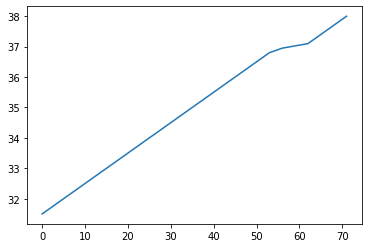

In [54]:
plt.plot(sigma2_layer_bounds)

In [55]:
# define time mean vvel at constant depth
vbar = ds_state['VVEL'].sel(time=slice(time_range[0], time_range[1])).mean(dim=['time']).compute()


In [56]:
meridional_volume_flux = ds_state['VVEL']*ds_state['drF']*ds_state['dxG']*ds_state['hFacS']
heat_content = grid.interp(ds_state['THETA']*ds_state['drF']*ds_state['hFacC'], 'Y', boundary='extend')
vertical_coordinate = xr.ones_like(ds_state['VVEL'])*ds_state['drF']

## Overturning circulations

'Residual', or total, overturning
$$
\Psi = \frac{1}{T}\int_{0}^{T} \oint \sum_{i = 1}^{N} v(x,y,\sigma_{2i})h(x,y,\sigma_{2i}) dx dt
$$

Eulerian-mean overturning
$$
\overline{\Psi} = \oint \sum_{i=1}^{N} \overline{v}(x,y,\sigma_{2i})\overline{h}(x,y,\sigma_{2i}) dx
$$

Transient eddy overturning
$$
\Psi^{*} = \Psi - \overline{\Psi}
$$

Could also define the transient eddy overturning by defining $v'$, and $h'$, but numerically this doesn't work so well.

Now, we want to break the Eulerian-mean overturning into standing meander and zonal-mean components.

Zonal-mean Eulerian-mean overturning
$$
<\Psi> = L \sum_{i=1}^{N} <\overline{v}>(y,\sigma_{2i}) <\overline{h}>(y,\sigma_{2i})
$$

Standing meander Eulerian-mean overturning
$$
\Psi_{SM} = \overline{\Psi} - <\Psi>
$$

In [57]:
from xhistogram.xarray import histogram


In [58]:
def cumsum_from_bottom (transposrts, dim='sigma2'):
    cumsum= (transposrts.cumsum(dim)-transposrts.sum(dim))
    return cumsum

In [59]:
layerwise_merid_vol_flux = histogram(sigma2, 
                          bins=[sigma2_layer_bounds], 
                          dim = ['Z'],
                          weights=meridional_volume_flux).rename({'sigma2_bin':'sigma2'})



In [60]:
%%time
psi = layerwise_merid_vol_flux.mean(dim='time').compute().rename('psi')

CPU times: user 19.6 s, sys: 931 ms, total: 20.5 s
Wall time: 30.8 s


In [61]:
psi_bar = histogram(sigma2_bar, 
                          bins=[sigma2_layer_bounds], 
                          dim = ['Z'],
                          weights=vbar*ds_state['drF']*ds_state['dxG']*
                                    ds_state['hFacS']).rename({'sigma2_bin':'sigma2'}).rename('psi_bar')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.histogram_bin_edges` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [62]:
hbar = histogram(sigma2_bar, 
                          bins=[sigma2_layer_bounds], 
                          dim = ['Z'],
                          weights=xr.ones_like(vbar)*ds_state['drF']).rename({'sigma2_bin':'sigma2'}).rename('hbar')



XL = np.tile(ds_state['YG'], (len(sigma2_layer_bounds)-1,1)).T


YL = -hbar.mean(dim=['XC']).cumsum(dim='sigma2').compute()




/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.histogram_bin_edges` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [63]:
# psi = layerwise_merid_vol_flux.sel(time=slice(time_range[0], time_range[1])).mean(dim='time').compute()

# # this uses time-mean of the layer velocities and thickness. Should instead use Eulerian-mean in depth, and then convert to layer
# # psi_bar = (layerwise_vbar*layerwise_hbar*ds_state['dxG']).compute()

# psi_bar = (vbar_converted_to_layers*hbar_converted_to_layers*ds_state['dxG']).compute()


psi_star = psi - psi_bar

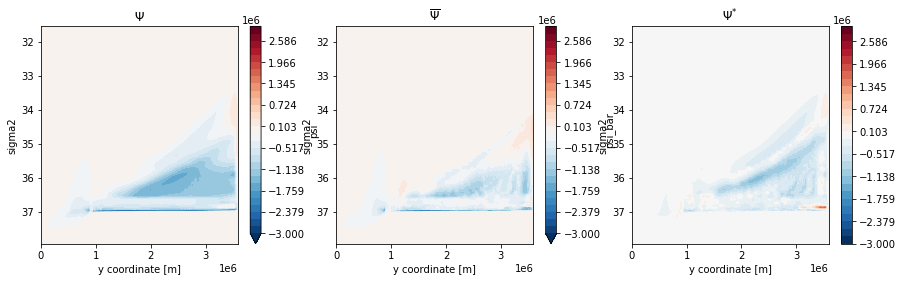

In [64]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
levels=np.linspace(-3,3,30,)*1e6

cumsum_from_bottom(psi.sum(dim='XC')).plot.contourf(ax=ax[0], y='sigma2', yincrease=False, robust=True, levels=levels)
ax[0].set_title('$\Psi$')

cumsum_from_bottom(psi_bar.sum(dim='XC')).plot.contourf(ax=ax[1], y='sigma2', yincrease=False, robust=True, levels=levels)
ax[1].set_title('$\overline{\Psi}$')


cumsum_from_bottom(psi_star.sum(dim='XC')).plot.contourf(ax=ax[2], y='sigma2', yincrease=False, robust=True, levels=levels)
ax[2].set_title('$\Psi^{*}$')


fig.savefig('psi_eddy_mean_sigma_space.png', dpi=200, bbox_inches='tight')

Text(0.5, 1.0, '$\\Psi^{*}$')

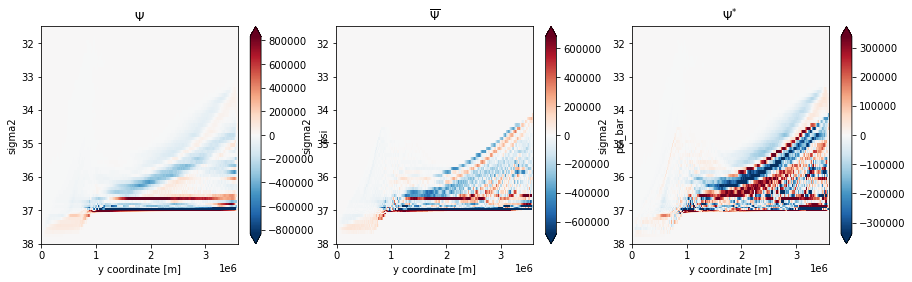

In [65]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

(psi.sum(dim='XC')).plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)
ax[0].set_title('$\Psi$')
# ax[0].set_ylim(37,36)

(psi_bar.sum(dim='XC')).plot(ax=ax[1], y='sigma2', yincrease=False, robust=True)
ax[1].set_title('$\overline{\Psi}$')


(psi_star.sum(dim='XC')).plot(ax=ax[2], y='sigma2', yincrease=False, robust=True)
ax[2].set_title('$\Psi^{*}$')





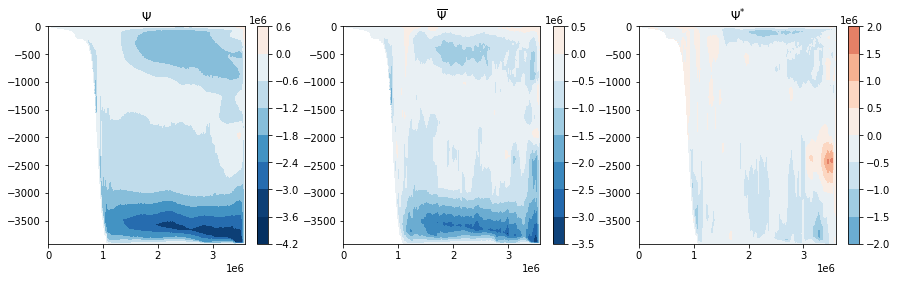

In [66]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].contourf(XL, YL, cumsum_from_bottom(psi.sum(dim='XC')), cmap='RdBu_r', vmin=-3.5e6, vmax=3.5e6)
ax[0].set_title('$\Psi$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].contourf(XL, YL, cumsum_from_bottom(psi_bar.sum(dim='XC')), cmap='RdBu_r', vmin=-3.5e6, vmax=3.5e6)
ax[1].set_title('$\overline{\Psi}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].contourf(XL, YL, cumsum_from_bottom(psi_star.sum(dim='XC')), cmap='RdBu_r', vmin=-3.5e6, vmax=3.5e6)
ax[2].set_title('$\Psi^{*}$')
plt.colorbar(im3, ax=ax[2])

# blue rotates counter-clockwise

fig.savefig('psi_eddy_mean_depth_space.png', dpi=200, bbox_inches='tight')

/jobfs/63912873.gadi-pbs/ipykernel_1007408/4166828815.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[0].pcolormesh(XL, YL, psi.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/4166828815.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax[1].pcolormesh(XL, YL, psi_bar.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/4166828815.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This

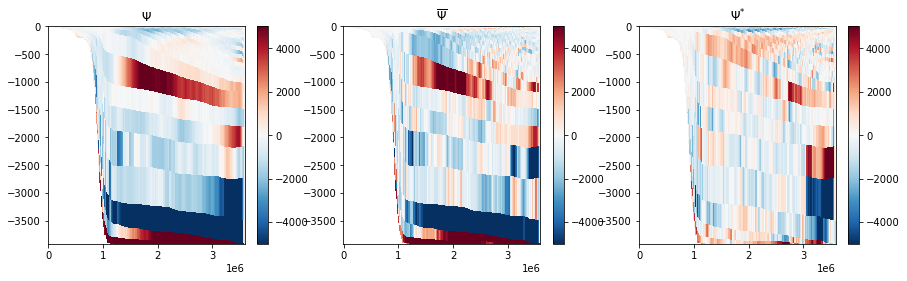

In [67]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, psi.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[0].set_title('$\Psi$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].pcolormesh(XL, YL, psi_bar.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[1].set_title('$\overline{\Psi}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(XL, YL, psi_star.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[2].set_title('$\Psi^{*}$')
plt.colorbar(im3, ax=ax[2])




### Calculate Standing meander overturning using Dufour et al. (2012) method
Define time average, zonal average $v$
Define time average, zonal averagh $h$
Compute $\Psi_{zm}$ from these. Get $\Psi_{sm}$ by difference.

In [68]:
# psi_zm  = xr.ones_like(layerwise_vbar)*((layerwise_vbar*ds_state['dxG']).mean(dim='XC')*layerwise_hbar.mean(dim='XC')).compute()
psi_zm = xr.ones_like(psi_bar)*histogram(sigma2_bar.mean(dim='XC'), 
                                          bins=[sigma2_layer_bounds], 
                                          dim = ['Z'],
                                          weights=(vbar*ds_state['drF']*ds_state['dxG']
                                                   *ds_state['hFacS']).mean(dim='XC')).rename(
                                                {'sigma2_bin':'sigma2'}).rename('psi_zm')






psi_zp = psi_bar - psi_zm


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.histogram_bin_edges` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


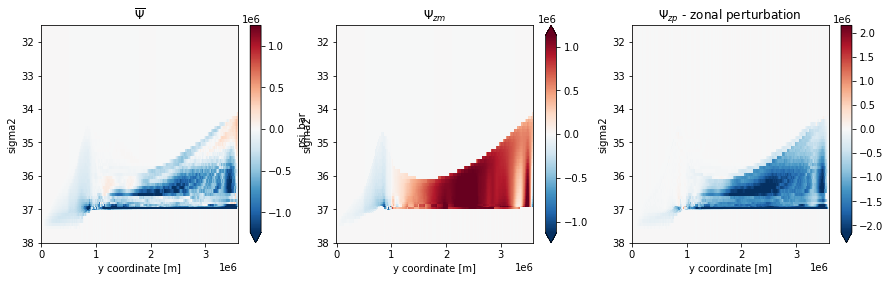

In [69]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

cumsum_from_bottom(psi_bar.sum(dim='XC')).plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)
ax[0].set_title('$\overline{\Psi}$')

cumsum_from_bottom(psi_zm.sum(dim='XC')).plot(ax=ax[1], y='sigma2', yincrease=False, robust=True)
ax[1].set_title('$\Psi_{zm}$')


cumsum_from_bottom(psi_zp.sum(dim='XC')).plot(ax=ax[2], y='sigma2', yincrease=False, robust=True)
ax[2].set_title('$\Psi_{zp}$ - zonal perturbation')



fig.savefig('psi_bar_decompostion_sigma_space.png', dpi=200, bbox_inches='tight')

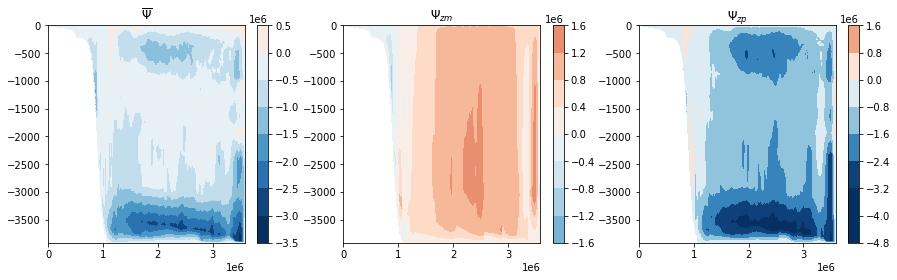

In [70]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].contourf(XL, YL, cumsum_from_bottom(psi_bar.sum(dim='XC')), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[0].set_title('$\overline{\Psi}$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].contourf(XL, YL, cumsum_from_bottom(psi_zm.sum(dim='XC')), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[1].set_title('$\Psi_{zm}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].contourf(XL, YL, cumsum_from_bottom(psi_zp.sum(dim='XC')), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[2].set_title('$\Psi_{zp}$')
plt.colorbar(im3, ax=ax[2])


# blue rotates counter-clockwise


fig.savefig('psi_bar_decompostion_depth_space.png', dpi=200, bbox_inches='tight')

/jobfs/63912873.gadi-pbs/ipykernel_1007408/2379751037.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[0].pcolormesh(XL, YL, psi_bar.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/2379751037.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax[1].pcolormesh(XL, YL, psi_zm.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/2379751037.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. T

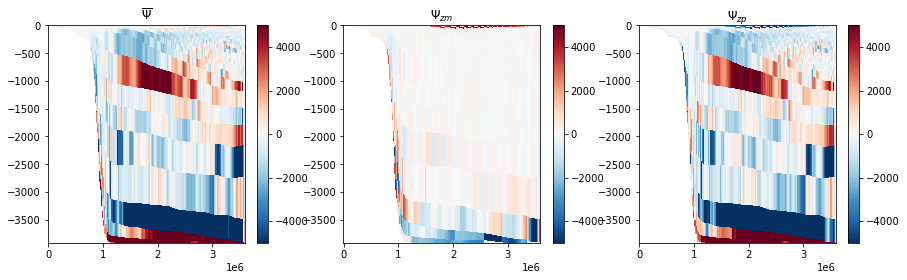

In [71]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, psi_bar.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[0].set_title('$\overline{\Psi}$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].pcolormesh(XL, YL, psi_zm.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[1].set_title('$\Psi_{zm}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(XL, YL, psi_zp.mean(dim='XC'), cmap='RdBu_r', vmin=-5e3, vmax=5e3)
ax[2].set_title('$\Psi_{zp}$')
plt.colorbar(im3, ax=ax[2])


# blue means southward flow



fig.savefig('psi_bar_decompostion_layer_flows_sigma_space.png', dpi=200, bbox_inches='tight')

## Heat transport

Use the framework from Naviero Garabato et al. (2017):

$$
T(C) = \int_{0}^{L}\sum_{i=1}^{N} v(x,y,i,t) h(x,y,i,t) C(x,y,i,t) ds,
$$

where $L$ is the length of the face through the flux is transported, $v$ is the velocity normal to the face, $h$ is the layer thickness, $C$ is the tracer concentration, $i$ is the layer, and there are $N$ layers in total.


We can break this up into advective and diffusive contributions. We can then further break up the advective contribution into zonal-mean and standing meander.

Test heat flux in standing meanders - is it eddy diffusion that does the work, standing meander fluxes, or zonal mean fluxes?

Define zonal mean as $<\cdot>$, zonal perturbation as $\tilde{\cdot}$, time-mean as $\overline{\cdot}$, and time perturbation as $\cdot'$.

Now we can time-average and expand $T(C)$ into different terms.

$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(\overline{v} \overline{h} + \overline{v' h'}\right) \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$

where the first term is the flux due to advection of the time-mean tracer by the overturning circulation and the second term is the flux due to eddy diffusion. The advective flux includes contributions from the time-mean overturning, $\overline{v} \overline{h}$, and the eddy-induced overturning, $\overline{v' h'}$. The time-mean overturning can be further broken down into zonal-mean and zonal-perturbation components.

$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(<\overline{v}> <\overline{h}> + \overline{\tilde{v}} \overline{\tilde{h}} \right) (<\overline{C}> + \overline{\tilde{C}}) + \overline{v' h'} \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$

Expanding terms and removing single perturbation terms, which integrate to zero, gives

$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(<\overline{v}> <\overline{h}> <\overline{C}>  + \overline{\tilde{v}} \overline{\tilde{h}} \right) (<\overline{C}> + \overline{\tilde{C}}) + \overline{v' h'} \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$



$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(<\overline{v}> <\overline{h}> <\overline{C}>  + \overline{\tilde{v}} \overline{\tilde{h}} \right) <\overline{C}> + \widetilde{(\overline{v}\overline{h})}\tilde{\overline{C}} + \overline{v' h'} \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$

$$
T(C) = <\overline{\Psi}><\overline{C}> + \Psi_{sm}\overline{C} + \Psi^{*}\overline{C} + \overline{(vh)'C'}
$$

### Reference temperature
For the temperature Fluxes, set a reference tempterature of -2°C. This will avoid the sign change at 0°C. BUT, this will make the comparison with `ADVx_TH` impossible, since that has an implicit reference temp of 0°C. So, when evaluating whether the budgests close, need to use 0°C as the reference.

In [72]:
Tref = -2.0

In [76]:
vh_prime = (layerwise_merid_vol_flux.sel(time=slice(time_range[0], time_range[1])) - psi)

# Need to use the linear transformation from xgcm for temperature, since it is not an
# extensive property. Using xhistogram results in some weird values.

# layerwise_temperature = histogram(sigma2, 
#                           bins=[sigma2_layer_bounds], 
#                           dim = ['Z'],
#                           weights=grid.interp(ds_state['THETA'], 'Y',
#                                               boundary='extend')).rename({'sigma2_bin':'sigma2'})

# linear interpolation from xgcm

layerwise_temperature = grid.transform(grid.interp(ds_state['THETA'] - Tref, 'Y', boundary='extend'),
                                          'Z',
                                          sigma2_layer_midpoints,
                                          method='linear',
                                          target_data=sigma2,
                                       mask_edges=False)

Tbar = ds_state['THETA'].mean(dim='time').load()

layerwise_Tbar = layerwise_temperature.mean(dim='time')

                    # grid.transform(grid.interp(Tbar - Tref, 'Y', boundary='extend'),
                    #                       'Z',
                    #                       sigma2_layer_midpoints,
                    #                       method='linear',
                    #                       target_data=sigma2_bar,
                    #                    mask_edges=False).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


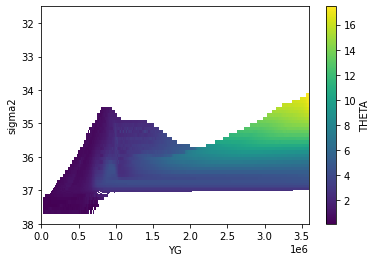

In [126]:
layerwise_Tbar.where(hbar>0.01).mean(dim='XC').plot(y='sigma2', yincrease=False)

/jobfs/63912873.gadi-pbs/ipykernel_1007408/656577707.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(XL, YL, layerwise_Tbar.where(hbar>0.01).mean(dim='XC'), cmap=cmocean.cm.thermal, vmin=-2, vmax=15)


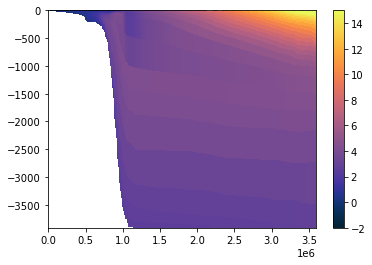

In [127]:
plt.pcolormesh(XL, YL, layerwise_Tbar.where(hbar>0.01).mean(dim='XC'), cmap=cmocean.cm.thermal, vmin=-2, vmax=15)
plt.colorbar()

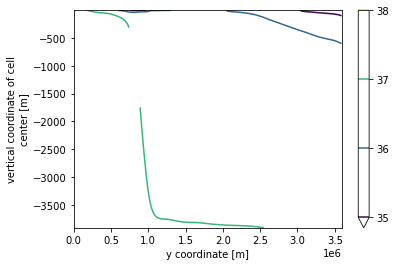

In [118]:
# Tbar.mean(dim='XC').plot()
im = sigma2_bar.mean(dim='XC').plot.contour(levels=[35, 36, 37, 38])
plt.colorbar(im)

In [75]:
vhc_reconstructed = layerwise_merid_vol_flux*layerwise_temperature
vhc_reconstructed_bar = vhc_reconstructed.mean(dim='time').compute()

In [77]:

Tprime = layerwise_temperature - layerwise_Tbar

# eddy diffusive transport
vh_prime_Tprime_bar = (vh_prime*Tprime).mean(dim='time').compute()


In [78]:
# Advective heat transport
psi_Tbar = psi*layerwise_Tbar

# is made up of Eulerian-mean and eddy

# Eulerian-mean overturning heat transport
psibar_Tbar = psi_bar*layerwise_Tbar
    # is made up of
    # zonal-mean
psizm_Tbar = psi_zm*layerwise_Tbar
    # standing meander
psizp_Tbar = psi_zp*layerwise_Tbar


# eddy overturning heat ransport
psistar_Tbar = psi_star*layerwise_Tbar


In [79]:
layerwise_heat_advection = histogram(sigma2, 
                          bins=[sigma2_layer_bounds], 
                          dim = ['Z'],
                          weights=ds_heat['ADVy_TH']).rename({'sigma2_bin':'sigma2'})




In [80]:

vhc_bar = layerwise_heat_advection.sel(time=slice(time_range[0],
                                                  time_range[1])).mean(dim='time').compute()

### Basin wide averages - does this method work?
Yes!

REMEMBER - need to use `Tref` = 0 for this comparison to be fair. Otherwise, expect the lines to not match perfectly.

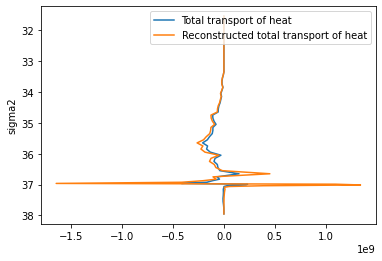

In [81]:
vhc_bar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Total transport of heat')

vhc_reconstructed_bar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Reconstructed total transport of heat')


plt.legend()

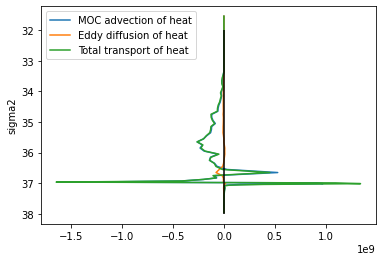

In [82]:
# 15 june - new attempt
(psi_Tbar).sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='MOC advection of heat')
(vh_prime_Tprime_bar).sum(dim=['XC','YG']).plot(y='sigma2', yincrease=False, label='Eddy diffusion of heat')
vhc_reconstructed_bar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Total transport of heat')

plt.legend()

plt.vlines(0, 38, 32, color='k')

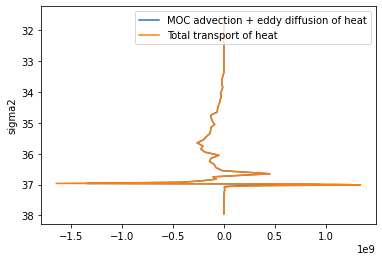

In [83]:
(psi_Tbar + vh_prime_Tprime_bar).sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='MOC advection + eddy diffusion of heat')
vhc_reconstructed_bar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Total transport of heat')

plt.legend()

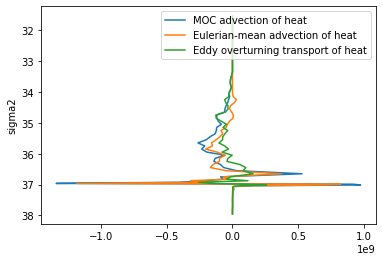

In [84]:
(psi_Tbar).sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='MOC advection of heat')
(psibar_Tbar).sum(dim=['XC','YG']).plot(y='sigma2', yincrease=False, label='Eulerian-mean advection of heat')
psistar_Tbar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Eddy overturning transport of heat')

plt.legend()

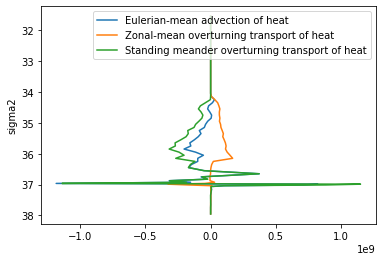

In [85]:
(psibar_Tbar).sum(dim=['XC','YG']).plot(y='sigma2', yincrease=False, label='Eulerian-mean advection of heat')
psizm_Tbar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Zonal-mean overturning transport of heat')

psizp_Tbar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Standing meander overturning transport of heat')


plt.legend()

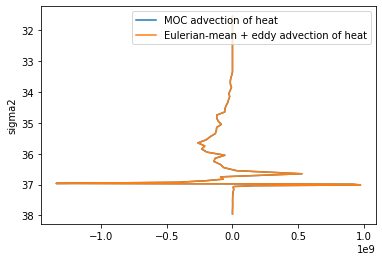

In [86]:
(psi_Tbar).sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='MOC advection of heat')
(psibar_Tbar + psistar_Tbar).sum(dim=['XC','YG']).plot(y='sigma2', yincrease=False, label='Eulerian-mean + eddy advection of heat')

plt.legend()

### Zonal-mean plots - where is this transport happening?

Text(0.5, 1.0, "$(vh)' T'$")

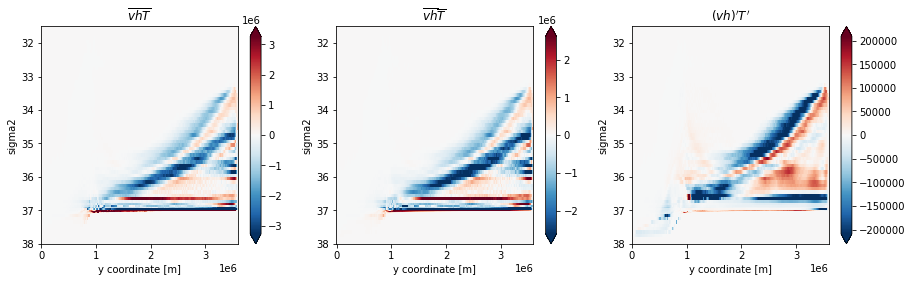

In [87]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_reconstructed_bar.sum(dim='XC').plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)
ax[0].set_title('$\overline{vhT}$')

psi_Tbar.sum(dim='XC').plot(ax=ax[1], y='sigma2', yincrease=False, robust=True)
ax[1].set_title('$\overline{vh} \overline{T}$')


vh_prime_Tprime_bar.sum(dim='XC').plot(ax=ax[2], y='sigma2', yincrease=False, robust=True)
ax[2].set_title("$(vh)' T'$")





/jobfs/63912873.gadi-pbs/ipykernel_1007408/1638231767.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[0].pcolormesh(XL, YL, vhc_reconstructed_bar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/1638231767.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax[1].pcolormesh(XL, YL, psi_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/1638231767.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or

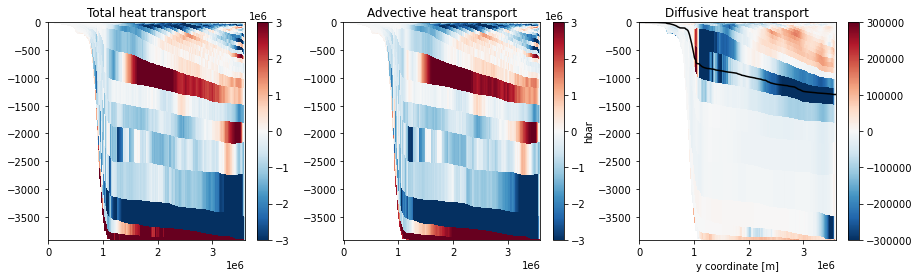

In [116]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, vhc_reconstructed_bar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[0].set_title('Total heat transport')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].pcolormesh(XL, YL, psi_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[1].set_title('Advective heat transport')
plt.colorbar(im2, ax=ax[1])


(-hbar.mean(dim='XC').cumsum(dim='sigma2').sel(sigma2=36.6, method='nearest')).plot(ax=ax[2], color='k')
im3 = ax[2].pcolormesh(XL, YL, vh_prime_Tprime_bar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e5, vmax=3e5)
ax[2].set_title('Diffusive heat transport')
plt.colorbar(im3, ax=ax[2])


fig.savefig('zonal_mean_heat_flux_depth_space.png', dpi=200, bbox_inches='tight')

/jobfs/63912873.gadi-pbs/ipykernel_1007408/3697228389.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[0].pcolormesh(XL, YL, psi_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/3697228389.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[1].pcolormesh(XL, YL, psibar_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/3697228389.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing

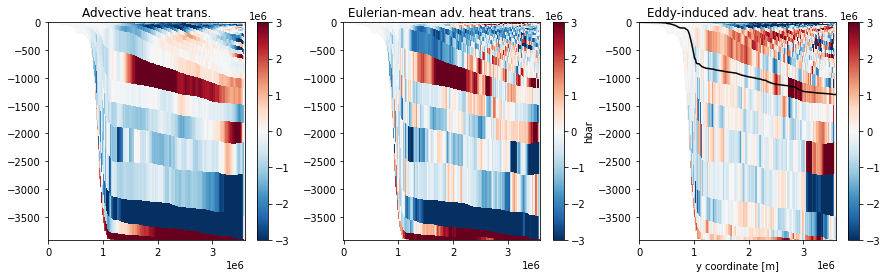

In [111]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, psi_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[0].set_title('Advective heat trans.')
plt.colorbar(im2, ax=ax[0])

im = ax[1].pcolormesh(XL, YL, psibar_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[1].set_title('Eulerian-mean adv. heat trans.')
plt.colorbar(im, ax=ax[1])


(-hbar.mean(dim='XC').cumsum(dim='sigma2').sel(sigma2=36.6, method='nearest')).plot(ax=ax[2], color='k')
im3 = ax[2].pcolormesh(XL, YL, psistar_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[2].set_title('Eddy-induced adv. heat trans.')
plt.colorbar(im3, ax=ax[2])



fig.savefig('zonal_mean_heat_flux_advection_decomposition_depth_space.png', dpi=200, bbox_inches='tight')

/jobfs/63912873.gadi-pbs/ipykernel_1007408/2071301816.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[0].pcolormesh(XL, YL, psibar_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/2071301816.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[1].pcolormesh(XL, YL, psizm_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
/jobfs/63912873.gadi-pbs/ipykernel_1007408/2071301816.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasi

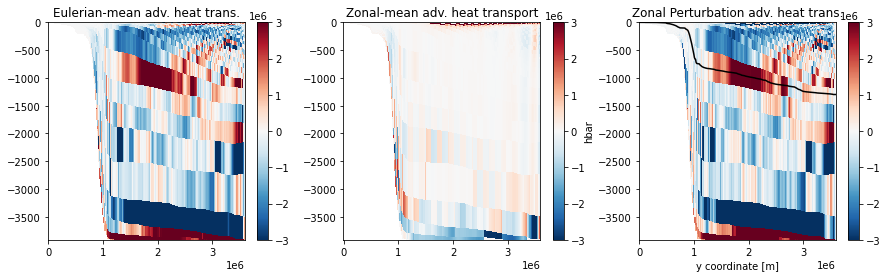

In [112]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL, psibar_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[0].set_title('Eulerian-mean adv. heat trans.')
plt.colorbar(im2, ax=ax[0])

im = ax[1].pcolormesh(XL, YL, psizm_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[1].set_title('Zonal-mean adv. heat transport')
plt.colorbar(im, ax=ax[1])


(-hbar.mean(dim='XC').cumsum(dim='sigma2').sel(sigma2=36.6, method='nearest')).plot(ax=ax[2], color='k')
im3 = ax[2].pcolormesh(XL, YL, psizp_Tbar.sum(dim='XC'), cmap='RdBu_r', vmin=-3e6, vmax=3e6)
ax[2].set_title('Zonal Perturbation adv. heat trans.')
plt.colorbar(im3, ax=ax[2])

fig.savefig('zonal_mean_and_perturbation_heat_flux_advection_decomposition_depth_space.png', dpi=200, bbox_inches='tight')

### x-y plots on a density surface


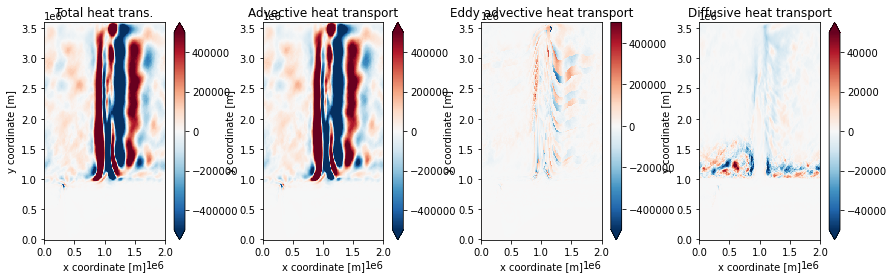

In [108]:
fig, ax = plt.subplots(1,4, figsize=(15,4))

plt_sigma = 36.6

vhc_reconstructed_bar.sel(sigma2=plt_sigma, method='nearest').plot(ax=ax[0], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])
ax[0].set_aspect('equal')



psi_Tbar.sel(sigma2=plt_sigma, method='nearest').plot(ax=ax[1], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')
ax[1].set_aspect('equal')

psistar_Tbar.sel(sigma2=plt_sigma, method='nearest').plot(ax=ax[2], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[2].set_title('Eddy advective heat transport')
ax[2].set_aspect('equal')

vh_prime_Tprime_bar.sel(sigma2=plt_sigma, method='nearest').plot(ax=ax[3], vmin=-5e4, vmax=5e4, cmap='RdBu_r')
ax[3].set_title('Diffusive heat transport')
ax[3].set_aspect('equal')




fig.savefig('density_surface_heat_flux_decomposition_{0}.png'.format(plt_sigma), dpi=200, bbox_inches='tight')

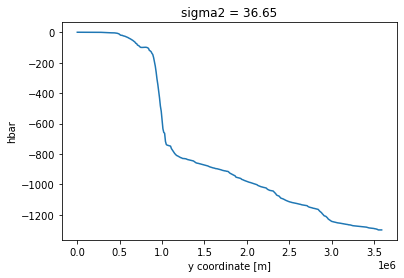

In [109]:
(-hbar.mean(dim='XC').cumsum(dim='sigma2').sel(sigma2=plt_sigma, method='nearest')).plot()

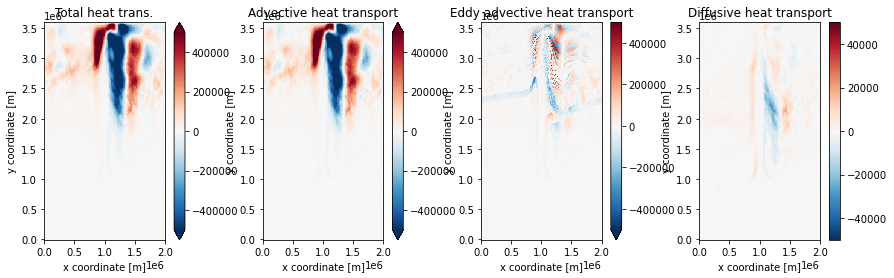

In [96]:
fig, ax = plt.subplots(1,4, figsize=(15,4))

plt_sigma = 35.8

vhc_reconstructed_bar.sel(sigma2=plt_sigma, method='nearest').plot(ax=ax[0], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])
ax[0].set_aspect('equal')



psi_Tbar.sel(sigma2=plt_sigma, method='nearest').plot(ax=ax[1], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')
ax[1].set_aspect('equal')

psistar_Tbar.sel(sigma2=plt_sigma, method='nearest').plot(ax=ax[2], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[2].set_title('Eddy advective heat transport')
ax[2].set_aspect('equal')

vh_prime_Tprime_bar.sel(sigma2=plt_sigma, method='nearest').plot(ax=ax[3], vmin=-5e4, vmax=5e4, cmap='RdBu_r')
ax[3].set_title('Diffusive heat transport')
ax[3].set_aspect('equal')




fig.savefig('density_surface_heat_flux_decomposition_{0}.png'.format(plt_sigma), dpi=200, bbox_inches='tight')

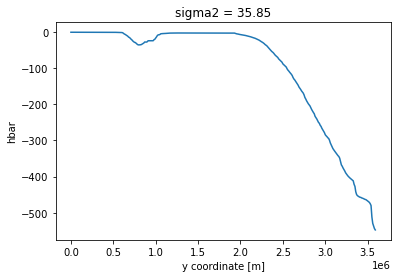

In [115]:
(-hbar.mean(dim='XC').cumsum(dim='sigma2').sel(sigma2=plt_sigma, method='nearest')).plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xgcm/grid.py:1643: UserWarning: Metric at ('YC',) being interpolated from metrics at dimensions ('YC', 'XG'). Boundary value set to 'extend'.
  warnings.warn(


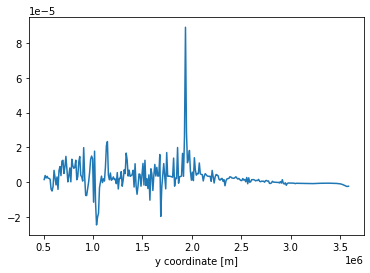

In [153]:
grid.derivative(layerwise_Tbar.where(hbar>0.01).sel(sigma2=plt_sigma,
                                                    method='nearest').mean(dim='XC'),
                'Y').mean('XG').plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xgcm/grid.py:1643: UserWarning: Metric at ('YC',) being interpolated from metrics at dimensions ('YC', 'XG'). Boundary value set to 'extend'.
  warnings.warn(


(-2.0, 2.0)

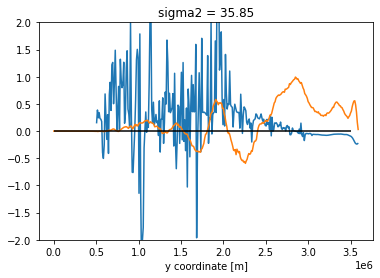

In [154]:
(grid.derivative(layerwise_Tbar.where(hbar>0.01).sel(sigma2=plt_sigma,
                                                    method='nearest').mean(dim='XC'),
                'Y').mean(dim='XG')*1e5).plot()

(vh_prime_Tprime_bar.sel(sigma2=plt_sigma, method='nearest').mean(dim='XC')/800).plot()

plt.hlines(0,0, 3.5e6, color='k')

plt.ylim(-2,2)

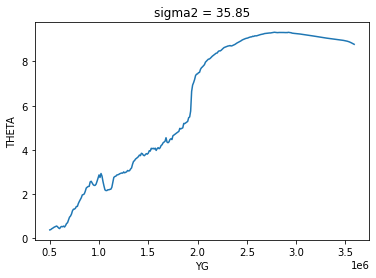

In [142]:
layerwise_Tbar.where(hbar>0.01).sel(sigma2=plt_sigma, method='nearest').mean(dim='XC').plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xgcm/grid.py:1643: UserWarning: Metric at ('YC', 'XC') being interpolated from metrics at dimensions ('YC', 'XG'). Boundary value set to 'extend'.
  warnings.warn(


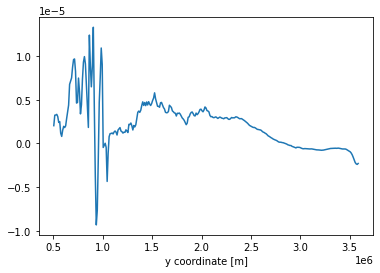

In [139]:
(grid.derivative(layerwise_Tbar.where(hbar>0.01).sel(sigma2=plt_sigma,
                                                    method='nearest'),
                'Y').mean(dim='XC')).plot()

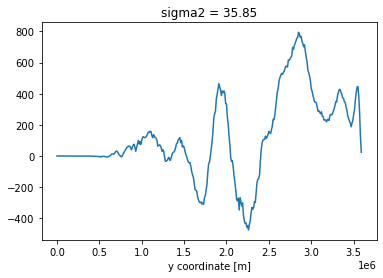

In [133]:
vh_prime_Tprime_bar.sel(sigma2=plt_sigma, method='nearest').mean(dim='XC').plot()

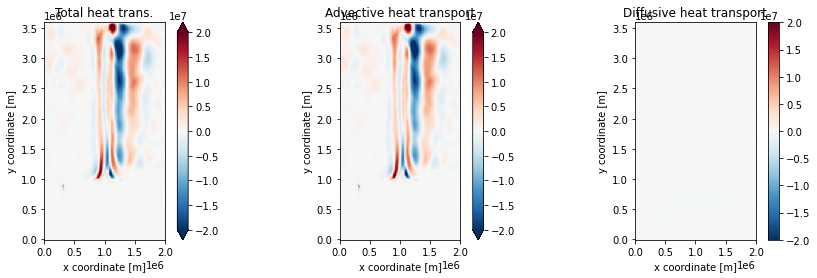

In [97]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_reconstructed_bar.sum(dim='sigma2').plot(ax=ax[0], vmin=-2e7, vmax=2e7, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])
ax[0].set_aspect('equal')



psi_Tbar.sum(dim='sigma2').plot(ax=ax[1], vmin=-2e7, vmax=2e7, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')
ax[1].set_aspect('equal')


# this is two order of magnitude smaller - shows up with vmin/vmax=2e5
vh_prime_Tprime_bar.sum(dim='sigma2').plot(ax=ax[2], vmin=-2e7, vmax=2e7, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')
ax[2].set_aspect('equal')




## Heat and volume transport onto the shelf

Begin with tansport over lines of latitude. Given the geomtry, this may be enough to get a good estimate of meridional heat flux over an isobath.

(37.5, 34.0)

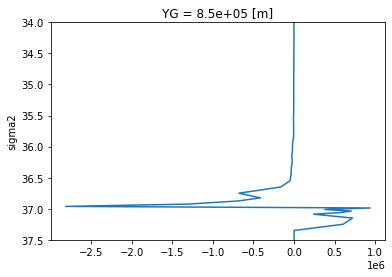

In [98]:
vhc_reconstructed_bar.sel(YG=0.85e6, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False)
plt.ylim(37.5, 34)

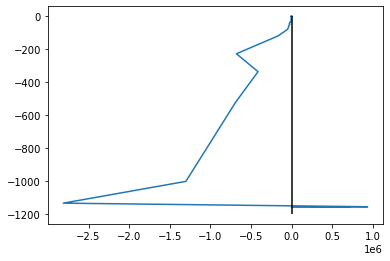

In [99]:
plt.plot(vhc_reconstructed_bar.sel(YG=0.85e6, method='nearest').sum(dim='XC'),
    -hbar.sel(YG=0.85e6, method='nearest').mean(dim='XC').cumsum(dim='sigma2'))
plt.vlines(0,-1200,0, colors='k')

/jobfs/63912873.gadi-pbs/ipykernel_1007408/2132855072.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(XL, YL, vhc_reconstructed_bar.sum(dim='XC'), vmin=-2e5, vmax=2e5, cmap='RdBu_r')


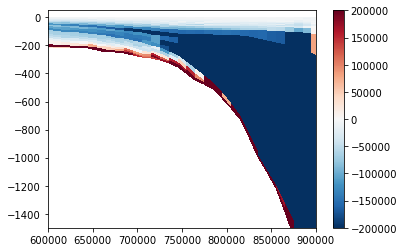

In [100]:
plt.pcolormesh(XL, YL, vhc_reconstructed_bar.sum(dim='XC'), vmin=-2e5, vmax=2e5, cmap='RdBu_r')
plt.xlim(0.6e6, 0.9e6)
plt.ylim(-1500, 50)
plt.colorbar()
# (-ds_state['Depth']).mean(dim='XC').plot(color='k')


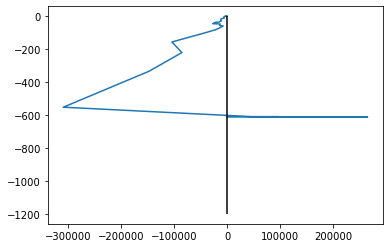

In [101]:
plt.plot(psi.sel(YG=0.8e6, method='nearest').sum(dim='XC'),
    -hbar.sel(YG=0.8e6, method='nearest').mean(dim='XC').cumsum(dim='sigma2'))
plt.vlines(0,-1200,0, colors='k')

/jobfs/63912873.gadi-pbs/ipykernel_1007408/399768239.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(XL, YL, psi.sum(dim='XC'), vmin=-1e5, vmax=1e5, cmap='RdBu_r')


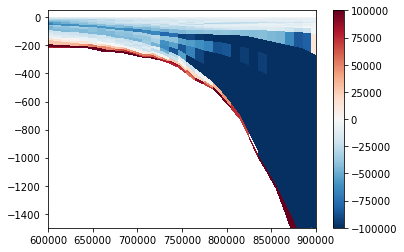

In [102]:
plt.pcolormesh(XL, YL, psi.sum(dim='XC'), vmin=-1e5, vmax=1e5, cmap='RdBu_r')
plt.xlim(0.6e6, 0.9e6)
plt.ylim(-1500, 50)
plt.colorbar()
# (-ds_state['Depth']).mean(dim='XC').plot(color='k')


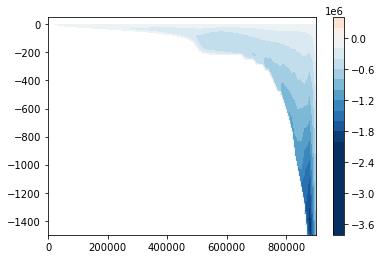

In [103]:
plt.contourf(XL, YL, cumsum_from_bottom(psi.sum(dim='XC')), vmin=-2e6, vmax=2e6, cmap='RdBu_r', levels=20)
plt.xlim(0.0e6, 0.9e6)
plt.ylim(-1500, 50)
plt.colorbar()
# (-ds_state['Depth']).mean(dim='XC').plot(color='k')



### Next steps: break the heat and volume transport down into the different terms

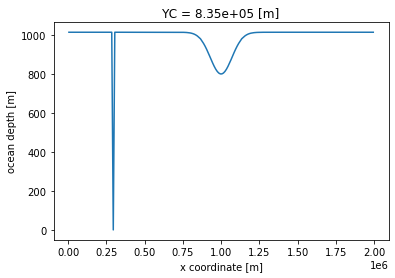

In [92]:
# y = 0.83e6 is roughly the 1000m isobath
ds_state['Depth'].sel(YC=0.83e6, method='nearest').plot()

In [93]:
X_shelf_plots = np.tile(ds_state['XC'], (len(sigma2_layer_bounds)-1,1)).T

# Y_shelf_plots = -hbar.sel(YG=yloc).cumsum(dim='sigma2').compute()

Text(0.5, 1.0, 'Diffusive heat transport')

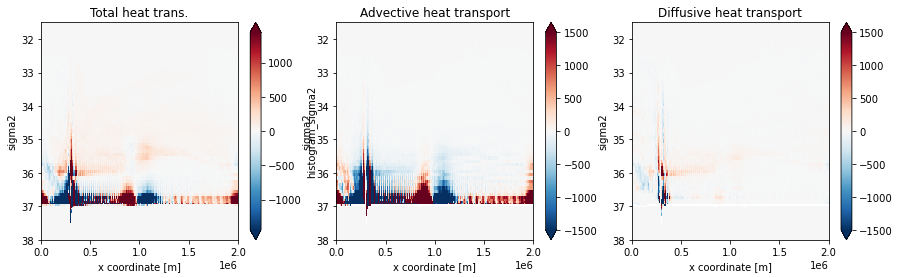

In [94]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sel(YG=0.83e6, method='nearest').plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)#, vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])


psi_Tbar.sel(YG=0.83e6, method='nearest').plot(ax=ax[1], y='sigma2', yincrease=False, vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')


vh_prime_Tprime_bar.sel(YG=0.83e6, method='nearest').plot(ax=ax[2], y='sigma2', yincrease=False, vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')



/jobfs/59546592.gadi-pbs/ipykernel_46961/3200113191.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1 = ax[0].pcolormesh(X_shelf_plots, Y_shelf_plots, vhc_bar.sel(YG=yloc, method='nearest'), vmin=-5e4, vmax=5e4, cmap='RdBu_r')
/jobfs/59546592.gadi-pbs/ipykernel_46961/3200113191.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax[1].pcolormesh(X_shelf_plots, Y_shelf_plots, psi_Tbar.sel(YG=yloc, method='nearest'), vmin=-5e4, vmax=5e4, cmap='RdBu_r')
/jobfs/59546592.gadi-pbs/ipykernel_46961/3200113191.py:16: UserWarning: The input coordinates to pcolormesh are interpre

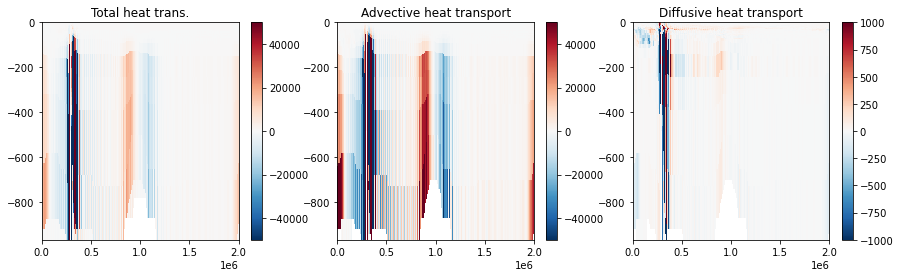

In [95]:
yloc = 0.83e6

Y_shelf_plots = -hbar.sel(YG=yloc).cumsum(dim='sigma2').compute()

fig, ax = plt.subplots(1,3, figsize=(15,4))

im1 = ax[0].pcolormesh(X_shelf_plots, Y_shelf_plots, vhc_bar.sel(YG=yloc, method='nearest'), vmin=-5e4, vmax=5e4, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
plt.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(X_shelf_plots, Y_shelf_plots, psi_Tbar.sel(YG=yloc, method='nearest'), vmin=-5e4, vmax=5e4, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')
plt.colorbar(im2, ax=ax[1])


im3 = ax[2].pcolormesh(X_shelf_plots, Y_shelf_plots, vh_prime_Tprime_bar.sel(YG=yloc, method='nearest'), vmin=-1e3, vmax=1e3, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')
plt.colorbar(im3, ax=ax[2])


Text(0.5, 1.0, 'Diffusive heat transport')

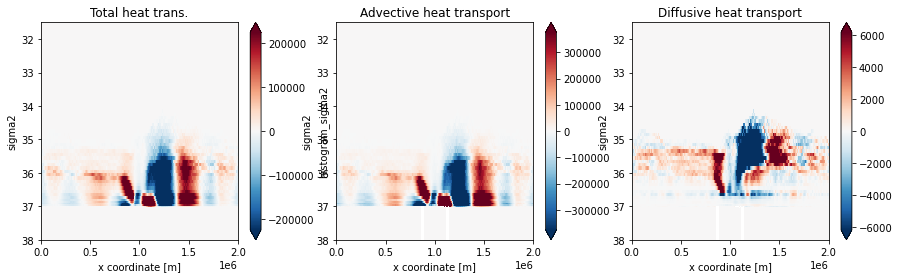

In [96]:
yloc = 2.5e6

fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sel(YG=yloc, method='nearest').plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)# vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])


psi_Tbar.sel(YG=yloc, method='nearest').plot(ax=ax[1], y='sigma2', yincrease=False, robust=True)# vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')


vh_prime_Tprime_bar.sel(YG=yloc, method='nearest').plot(ax=ax[2], y='sigma2', yincrease=False, robust=True)# vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')


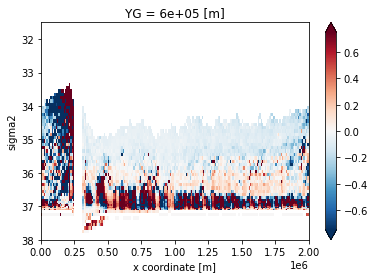

In [97]:
(vh_prime_Tprime_bar/vhc_bar).sel(YG=0.6e6, method='nearest').plot(y='sigma2', yincrease=False, vmin=-0.75, vmax=0.75, cmap='RdBu_r')


/jobfs/59546592.gadi-pbs/ipykernel_46961/348213675.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1 = ax[0].pcolormesh(X_shelf_plots, Y_shelf_plots, vhc_bar.sel(YG=yloc, method='nearest'), vmin=-5e5, vmax=5e5, cmap='RdBu_r')
/jobfs/59546592.gadi-pbs/ipykernel_46961/348213675.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax[1].pcolormesh(X_shelf_plots, Y_shelf_plots, psi_Tbar.sel(YG=yloc, method='nearest'), vmin=-5e5, vmax=5e5, cmap='RdBu_r')
/jobfs/59546592.gadi-pbs/ipykernel_46961/348213675.py:16: UserWarning: The input coordinates to pcolormesh are interpreted

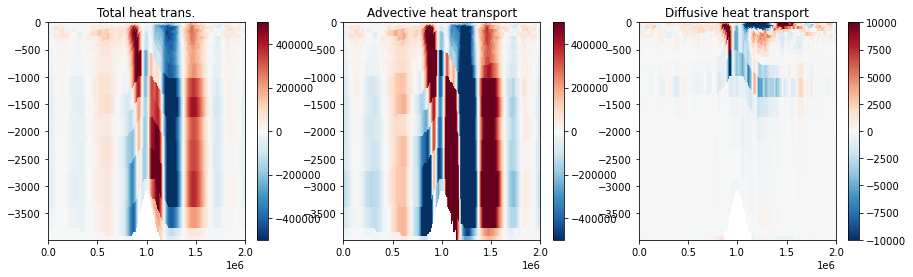

In [98]:
yloc = 2.5e6

Y_shelf_plots = -hbar.sel(YG=yloc).cumsum(dim='sigma2').compute()

fig, ax = plt.subplots(1,3, figsize=(15,4))

im1 = ax[0].pcolormesh(X_shelf_plots, Y_shelf_plots, vhc_bar.sel(YG=yloc, method='nearest'), vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
plt.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(X_shelf_plots, Y_shelf_plots, psi_Tbar.sel(YG=yloc, method='nearest'), vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')
plt.colorbar(im2, ax=ax[1])


im3 = ax[2].pcolormesh(X_shelf_plots, Y_shelf_plots, vh_prime_Tprime_bar.sel(YG=yloc, method='nearest'), vmin=-1e4, vmax=1e4, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')
plt.colorbar(im3, ax=ax[2])


### Heat and volume transport over lines of latitude

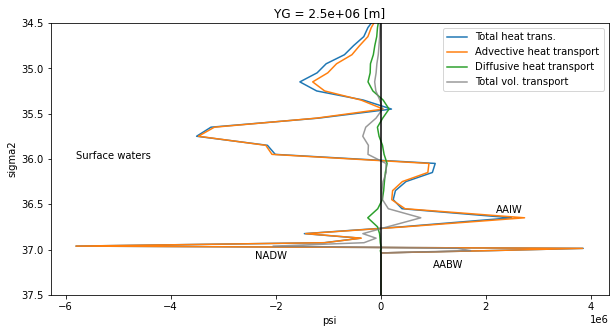

In [99]:
yloc = 2.5e6

plt.figure(figsize=(10,5))

(psi_Tbar + vh_prime_Tprime_bar).sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Total heat trans.')

psi_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Advective heat transport')

vh_prime_Tprime_bar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Diffusive heat transport')

psi.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Total vol. transport', color='grey', alpha=0.8)



plt.vlines(0, 38,32, 'k')
plt.legend()
plt.ylim(37.5,34.5)

plt.text(-2.4e6, 37.1, 'NADW')
plt.text(-5.8e6, 36, 'Surface waters')
plt.text(2.2e6, 36.6, 'AAIW')
plt.text(1e6, 37.2, 'AABW')



plt.savefig('y=2.5e6_heat_volume_fluxes.png', dpi=200, bbox_inches='tight')

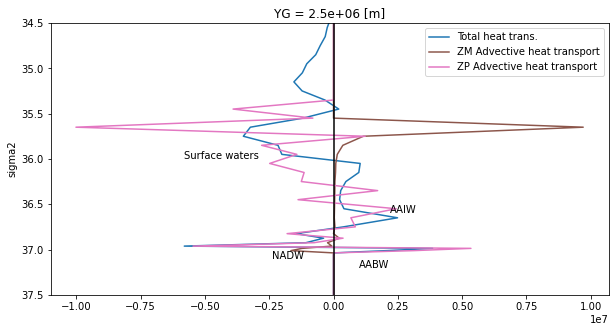

In [100]:
yloc = 2.5e6

plt.figure(figsize=(10,5))

(psi_Tbar + vh_prime_Tprime_bar).sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Total heat trans.', color='C0')

# vh_prime_Tprime_bar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Diffusive heat transport', color='C1')

# psi_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Advective heat transport', color='C2')


# psibar_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Eulerian-mean Advective heat transport', color='C3')

# psistar_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Eddy Advective heat transport', color='C4')



psizm_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='ZM Advective heat transport', color='C5')

psizp_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='ZP Advective heat transport', color='C6')




# psi.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Total vol. transport', color='grey', alpha=0.8)



plt.vlines(0, 38,32, 'k')
plt.legend()
plt.ylim(37.5,34.5)

plt.text(-2.4e6, 37.1, 'NADW')
plt.text(-5.8e6, 36, 'Surface waters')
plt.text(2.2e6, 36.6, 'AAIW')
plt.text(1e6, 37.2, 'AABW')





plt.savefig('y=2.5e6_heat_volume_fluxes_flow_decomposition_3.png', dpi=200, bbox_inches='tight')

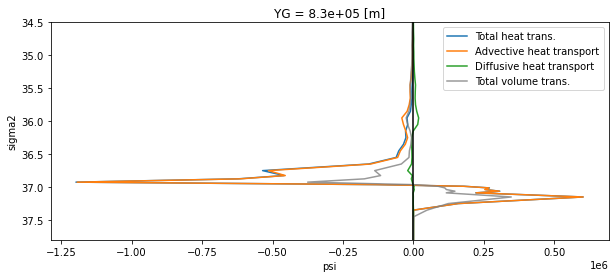

In [101]:
yloc = 0.83e6

plt.figure(figsize=(10,4))

(vh_prime_Tprime_bar + psi_Tbar).sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Total heat trans.')
psi_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Advective heat transport')
vh_prime_Tprime_bar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Diffusive heat transport')

psi.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Total volume trans.', color='grey', alpha=0.8)


plt.vlines(0,38,32, 'k')
plt.legend()
plt.ylim(37.8,34.5)



plt.savefig('y=0.83e6_heat_volume_fluxes.png', dpi=200, bbox_inches='tight')



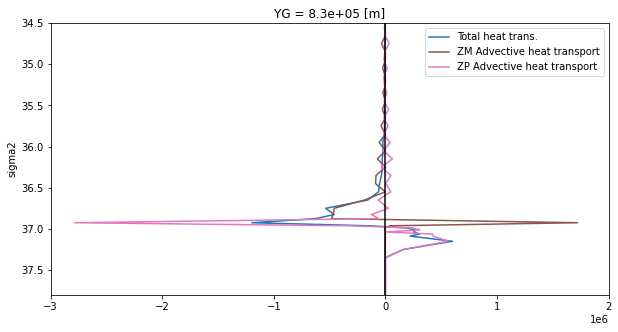

In [102]:
yloc = 0.83e6

plt.figure(figsize=(10,5))

(psi_Tbar + vh_prime_Tprime_bar).sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Total heat trans.', color='C0')

# vh_prime_Tprime_bar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Diffusive heat transport', color='C1')

# psi_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Advective heat transport', color='C2')


# psibar_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Eulerian-mean advective heat transport', color='C3')

# psistar_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Eddy Advective heat transport', color='C4')



psizm_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='ZM Advective heat transport', color='C5')

psizp_Tbar.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='ZP Advective heat transport', color='C6')



# psi.sel(YG=yloc, method='nearest').sum(dim='XC').plot(y='sigma2', yincrease=False, label='Total vol. transport', color='grey', alpha=0.8)



plt.vlines(0, 38,32, 'k')
plt.legend()
plt.ylim(37.8,34.5)
plt.xlim(-3e6, 2e6)

plt.savefig('y=0.83e6_heat_fluxes_3.png', dpi=200, bbox_inches='tight')


